<img src="Ufo-icon.png" height="256" width="256" style="float: right">

# A Needle in a Data Haystack - Final Project
## Matan Cohen, Nir Schipper & Ran Shaham
### Exploring UFO sightings data (or - ARE ALIENS REAL?)

#### Contents
<span id="the-top" />
We explore UFO sightings data by:
- [Shapes](#Shapes)
- [Duration](#Duration)
- [Location](#Locations)
- [Time of day](#Time)

If running interactively, start by selecting `Cell` from the menu, and click `Run All`. This will run the code in the notebook and plot the graphs and widgets.

### Initialization

In [1]:
# imports
# standard library
import re
import json
import html
import datetime as dt
# 3rd party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets

In [2]:
# constants
UFO_FILE = 'scrubbed.csv'
DRONES_FILE = 'drones_google.csv'
POP_DENSITY_FILE = 'pop_density.csv'
POP_ESTIMATE_FILE = 'pop_estimate.csv'
NAME_TO_CODE_FILE = 'state_name_to_code.json'
# column names
DATETIME = 'datetime'
YEAR = 'year'
MONTH = 'month'
DAY = 'day'
HOUR = 'hour'
COUNTRY = 'country'
STATE = 'state'
SHAPE = 'shape'
COUNT = 'count'
DUR_HOURS = 'duration (hours/min)'
DUR_SECONDS = 'duration (seconds)'
DURATION = 'duration'
DESCRIPTION = 'comments'
LAT = 'latitude'
LON = 'longitude'
# etc
DATE_FORMAT = '%m/%d/%Y %H:%M'
FIX_TIME_REGEX = (r'\s24:(\d{2})\s*$', r' 00:\1')

In [3]:
# magic & settings
%matplotlib inline
# big, juicy plots
sns.set_context('talk')
LARGE_FIGSIZE = (12, 8)
sns.set_style(style='white', rc={'figsize': LARGE_FIGSIZE})
plt.rcParams.update({
    'figure.figsize': LARGE_FIGSIZE,
})

### Read & Clean the dataset

Read the csv file:

In [4]:
data = pd.read_csv(UFO_FILE, low_memory=False)
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


and clean it up:

In [5]:
# make comments readable (unescape html)
data.loc[:, DESCRIPTION] = data[DESCRIPTION].apply(lambda val: html.unescape(str(val)))

# parse datetime - fix 24h format first (24:xx --> 00:xx)
# and insert time columns (year, month, day and hour)
data.loc[:, DATETIME] = data[DATETIME].apply(lambda val: re.sub(*FIX_TIME_REGEX, str(val)))
data.loc[:, DATETIME] = pd.to_datetime(data[DATETIME], format=DATE_FORMAT, errors='coerce')

data.insert(1, YEAR, data[DATETIME].dt.year)
data.loc[:, YEAR] = data[YEAR].fillna(0).astype(int)
data.insert(2, MONTH, data[DATETIME].dt.month)
data.loc[:, MONTH] = data[MONTH].fillna(0).astype(int)
data.insert(3, HOUR, data[DATETIME].dt.hour)
data.loc[:, HOUR] = data[HOUR].fillna(0).astype(int)

# tidy up the rest of the textual columns
data.loc[:, 'city'] = data['city'].str.title()
for col in ['state', 'country']:
    data.loc[:, col] = data[col].str.upper()

# parse location data
data[LAT] = pd.to_numeric(data[LAT], errors='coerce')
data = data.rename(columns={'longitude ': LON})

# drop the duration in hours column and rename the one with the seconds
data = data.drop(DUR_HOURS, axis=1)
data = data.rename(columns={DUR_SECONDS: DURATION})

# get a list of all years with sightings
years = np.unique(data[YEAR])

# display the result
data.head()

,datetime,year,month,hour,city,state,country,shape,duration,comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,1949,10,20,San Marcos,TX,US,cylinder,2700,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111
1,1949-10-10 21:00:00,1949,10,21,Lackland Afb,TX,NaN,light,7200,"1949 Lackland AFB, TX. Lights racing across t...",12/16/2005,29.384210,-98.581082
2,1955-10-10 17:00:00,1955,10,17,Chester (Uk/England),NaN,GB,circle,20,"Green/Orange circular disc over Chester, England",1/21/2008,53.200000,-2.916667
3,1956-10-10 21:00:00,1956,10,21,Edna,TX,US,circle,20,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833
4,1960-10-10 20:00:00,1960,10,20,Kaneohe,HI,US,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611


Done! Now for some stats on the file:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 13 columns):
datetime       80332 non-null datetime64[ns]
year           80332 non-null int64
month          80332 non-null int64
hour           80332 non-null int64
city           80332 non-null object
state          74535 non-null object
country        70662 non-null object
shape          78400 non-null object
duration       80332 non-null object
comments       80332 non-null object
date posted    80332 non-null object
latitude       80331 non-null float64
longitude      80332 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 8.0+ MB


An important thing to note about this dataset is that it grows over time. That is, the number of sightings (per year) is increasing as time passes. Let's plot it:

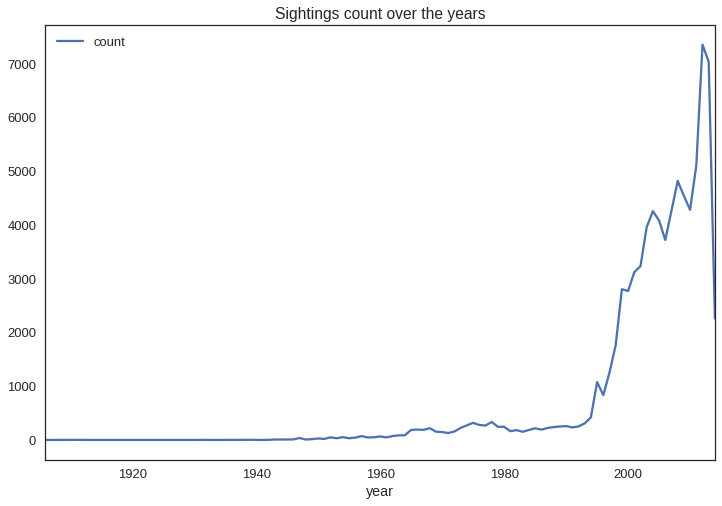

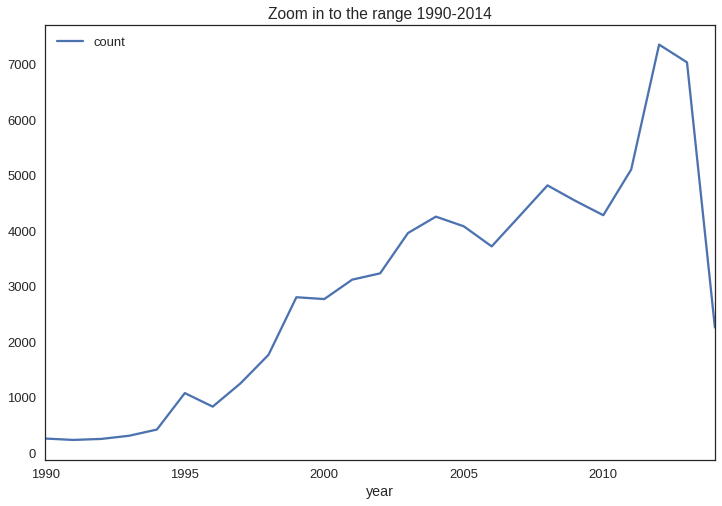

In [7]:
count = data[YEAR].value_counts()
count.name = COUNT
count.reset_index().sort_values(by='index').plot(x='index', y=COUNT);
plt.xlabel(YEAR);
plt.title('Sightings count over the years');

interesting_years = [year for year in range(1990, 2015)]
count.loc[interesting_years].reset_index().plot(x='index', y=COUNT);
plt.xlabel(YEAR);
plt.title('Zoom in to the range 1990-2014');

This, in our opinion, is correlated to the development of internet technologies such as search engines, that made the reporting mechanism more efficient and thus more people managed to report.

### Shapes

[[back to the top]](#the-top)

First, we extract the unique shape values from all sightings:

In [8]:
shapes = pd.unique(data[SHAPE])
shapes = [shape for shape in shapes if not pd.isnull(shape)]

... and for every year, get the proportion of sightings with a given shape:

In [9]:
# get the distribution of each shape for every year
def get_shape_distribution(shape, data):
    if len(data) > 0:
        return len(data.loc[data[SHAPE] == shape, SHAPE]) / len(data)
    else:
        return 0

shapes_dist = pd.DataFrame(columns=[YEAR, SHAPE, COUNT]).set_index([YEAR, SHAPE])
for year in years:
    year_data = data.loc[data[YEAR] == year, :]
    shapes_distributions = {shape: get_shape_distribution(shape, year_data)
                            for shape in shapes}
    for shape in shapes:
        shapes_dist.loc[(year, shape), COUNT] = shapes_distributions[shape]

Use the following widget to explore the change in shapes in sightings over the years.

_Pro tip: The real action starts at ~1950..._

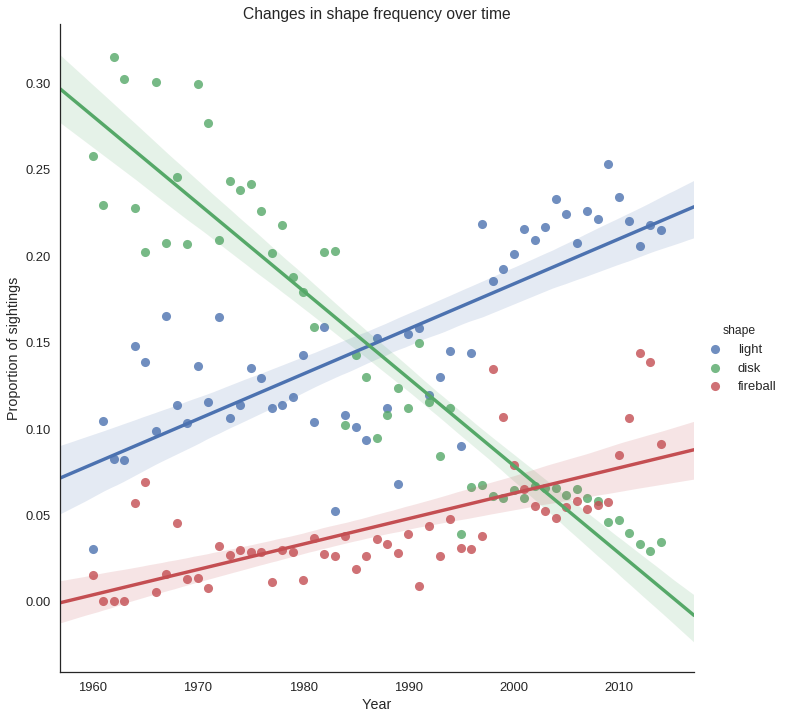

In [10]:
interesting_years = (1960, 2014)

select_years_widget = widgets.widgets.IntRangeSlider(
    min = years[0],
    max = years[-1],
    value = interesting_years,
    step = 1,
    description = 'Years range'
)

select_shapes_widget = widgets.widgets.SelectMultiple(
    options = shapes,
    value = ['disk', 'light', 'fireball'],
    description = 'Shapes to plot. Use Ctrl to select multiple values:',
    disabled = False
)

# an interactive plotting function
@widgets.interact(years_range=select_years_widget,
                  selected_shapes=select_shapes_widget)
def plot_shape_distributions(years_range, selected_shapes):
    # get all years in the selected range
    selected_years = years[(years >= years_range[0]) & 
                           (years <= years_range[1])]
    selected_data = shapes_dist.loc[(selected_years, selected_shapes), COUNT].reset_index()
    # plot & format
    sns.lmplot(x=YEAR, y=COUNT, hue=SHAPE, data=selected_data, size=10)
    plt.title('Changes in shape frequency over time')
    plt.xlabel('Year')
    plt.ylabel('Proportion of sightings')

_We get a lot less disk-shaped UFOs these days. What a shame - I liked those._

But wait - there's more!

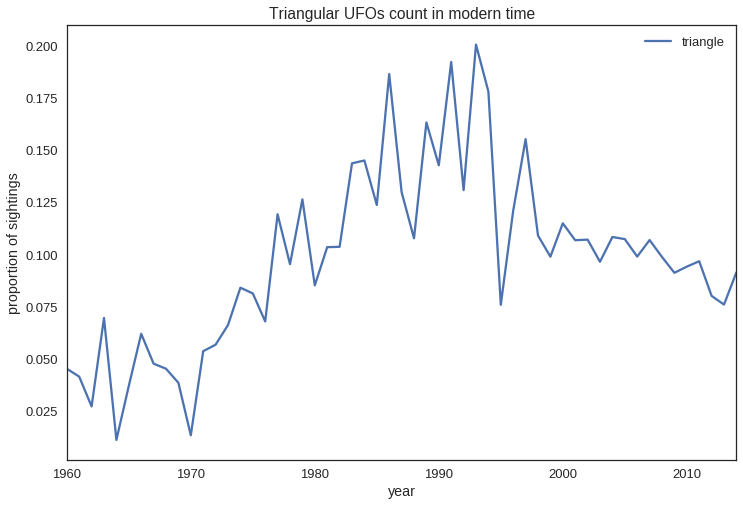

In [11]:
selected_years = years[(years >= interesting_years[0]) &
                       (years <= interesting_years[1])]
shapes_dist.loc[(selected_years, ['triangle']), COUNT].reset_index().plot(x=YEAR, y=COUNT);
plt.ylabel('proportion of sightings');
plt.title('Triangular UFOs count in modern time');
plt.legend(['triangle']);

___Fun fact:___
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a1/F-117_Nighthawk_Front.jpg" height="300" width="200" style="float: right; margin-left: 10px">
The first operational aircraft to be designed around 'stealth technology' was the [Lockhead F-117 Nighthawk](https://en.wikipedia.org/wiki/Lockheed_F-117_Nighthawk). It was introduced in 1983 after having its first flight in 1981. It was officialy retired in 2008. Oh - and it looks like a big, black triangle in the sky.

Also, the [B-2 stealth bomber](https://en.wikipedia.org/wiki/Northrop_Grumman_B-2_Spirit) (which is triangular as well) was produced in the years 1987-2000, and its shape is even weirder. 

These could account for the dramatically higher proportion of triangular shaped UFO sightings in those years (note that most of the sightings in our dataset are [from the US](#Locations), where these aircrafts were present).

### Duration

[[back to the top]](#the-top)

In [12]:
SELECTED_COUNTRIES = ['AU', 'GB', 'US', 'CA']
import collections
def calcduration(duration):
    s = 0
    disqualified = 0
    for d in duration:
        try:
            #eliminate outliers
            #if a sighting lasts more than two days
            if(float(d)/3600 < 48):
                s = s+(float(d)/60)
            else:
                disqualified = disqualified+1
        except:
            pass
    return s,disqualified

def averageDurationPerYear():
    averageDurationPerYear = {}
    for year in years:
        num_sightings = len(data.loc[data[YEAR] == year, :])
        duration = data.loc[data[YEAR] == year, DURATION]
        [sumOfDurations,disqualified] = calcduration(duration)
        averageDurationPerYear[year] = sumOfDurations/(num_sightings-disqualified)

    x = []
    y = []
    averageDurationPerYear = collections._OrderedDictItemsView(averageDurationPerYear)
    for key,val in averageDurationPerYear:
        x.append(key)
        y.append(val)
    plt.xlabel('Year')
    plt.ylabel('average time ogf sighting in minutes ')
    plt.title('average time of sighting each year')
    plt.plot(x, y)

def averageDurationPerCountry():
    averageDurationPerCountry = {}
    for country in SELECTED_COUNTRIES:
        num_sightings = len(data.loc[data[COUNTRY] == country , :])
        duration = data.loc[data[COUNTRY] == country, DURATION]
        [sumOfDurations,disqualified] = calcduration(duration)
        averageDurationPerCountry[country] = sumOfDurations/(num_sightings - disqualified)
    x = []
    y = []

    for key,val in averageDurationPerCountry.items():
        x.append(key)
        y.append(val)
    plt.figure()
    plt.xlabel('country')
    plt.ylabel('average time of sighting in minutes ')
    plt.title('average time of sighting per counrty')
    y_pos = np.arange(len(x))
    plt.bar(y_pos, y, align = 'center')
    plt.xticks(y_pos,x)

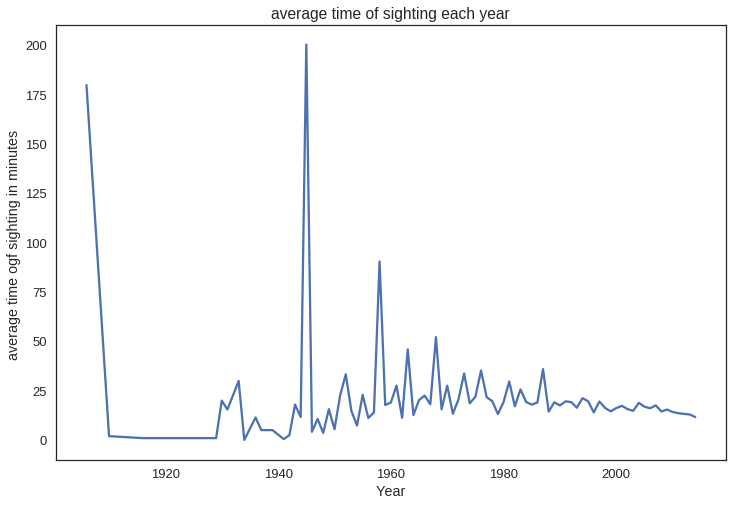

In [13]:
averageDurationPerYear()

In the graph above, we can see two major spikes. one is in the beginning (1906) when there was only one long sighting and a second spike in the mid 1940's. however, we can see that throughout the past 30 years there have been no major spikes (and even before the spikes were much less extreme). this can be attributed to the development of better means of documentation (in the absence of which, inventing accounts of alien invasions would have been easier) and also to better dissemination of information about events which account for strange sightings that might have been percieved as alien sightings.

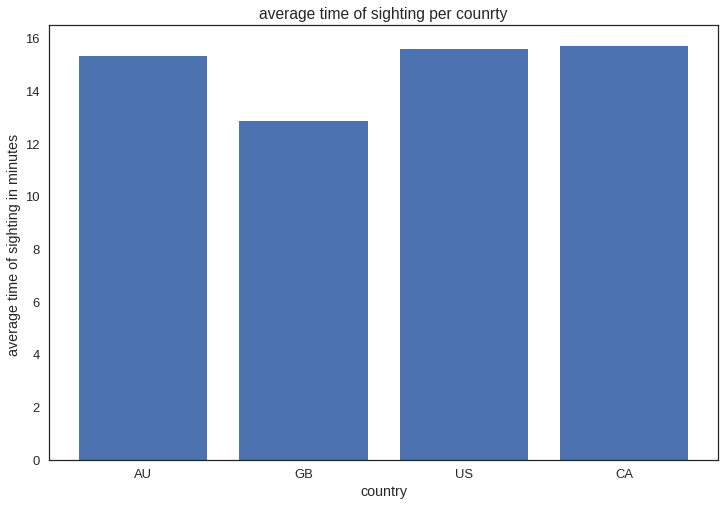

In [14]:
averageDurationPerCountry()

### Locations

[[back to the top]](#the-top)

_We had a hard time with maps, so this analysis is kind of awkward, but we did put a lot of thought into it._

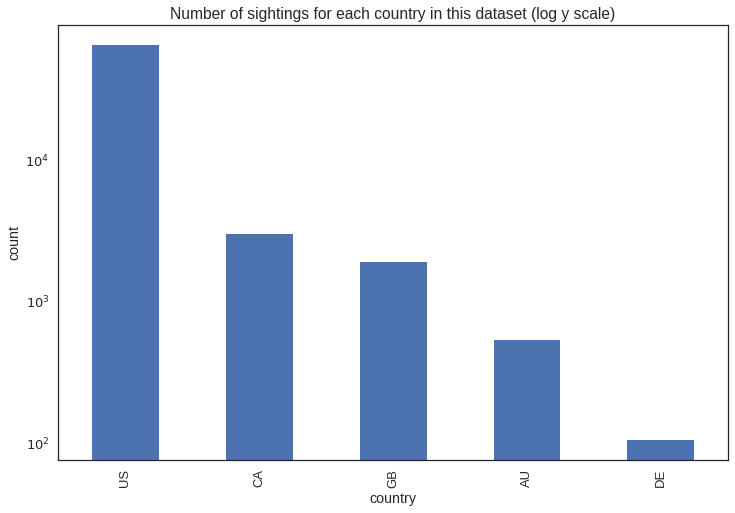

In [15]:
data[COUNTRY].value_counts().plot.bar(logy=True);
plt.xlabel(COUNTRY);
plt.ylabel(COUNT);
plt.title('Number of sightings for each country in this dataset (log y scale)');

This dataset consists mainly of sightings from the US. It was scraped from the [NUFORC](http://www.nuforc.org/), which is an American organization with a website in English. Therefore non English speaking UFO sighters are probably not included in this dataset.

From now on, we'll focus on US sightings.

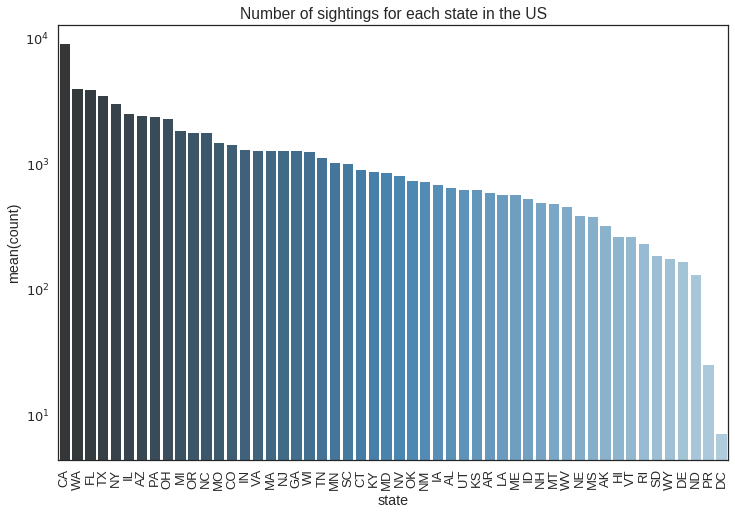

In [16]:
states_data = data.loc[data[COUNTRY] == 'US', STATE]
states_data = states_data.value_counts().reset_index().rename(
    columns={STATE: COUNT, 'index': STATE})
sns.barplot(x=STATE, y=COUNT, data=states_data, log=True, palette='Blues_d');
plt.xticks(rotation=90);
plt.title('Number of sightings for each state in the US');

In [17]:
# set the index of the population data to be the state name
states_data = states_data.set_index(STATE)

In [18]:
# read density and population estimate data
with open(NAME_TO_CODE_FILE) as f:
    name_to_code = json.load(f)

population = pd.read_csv(POP_ESTIMATE_FILE, 
                         converters={STATE: lambda s: name_to_code[s]}).set_index(STATE)
density = pd.read_csv(POP_DENSITY_FILE,
                      converters={STATE: lambda s: name_to_code[s]}).set_index(STATE)

In [19]:
PER_CAPITA = 100000

states_data['normalized_by_population'] = states_data[COUNT] / population['estimate'] * PER_CAPITA
states_data['normalized_by_density'] = states_data[COUNT] / density['density']
states_data.head()

,count,normalized_by_population,normalized_by_density
state,,,
CA,8912,23.871843,0.003748
WA,3966,58.814579,0.003473
FL,3835,20.345801,0.005096
TX,3447,13.654562,0.000885
NY,2980,15.358735,0.000327


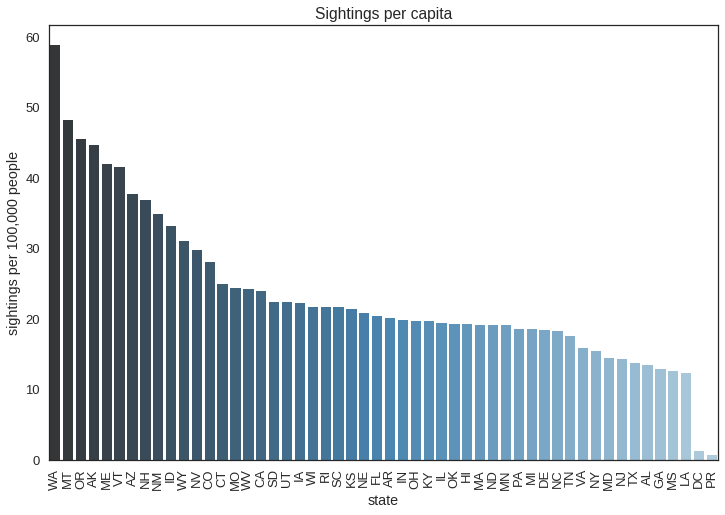

In [20]:
sns.barplot(x='state', y='normalized_by_population', 
            data=states_data.reset_index().sort_values(by='normalized_by_population', ascending=False),
            palette='Blues_d');
plt.xticks(rotation=90);
plt.ylabel('sightings per {:,} people'.format(PER_CAPITA));
plt.title('Sightings per capita');

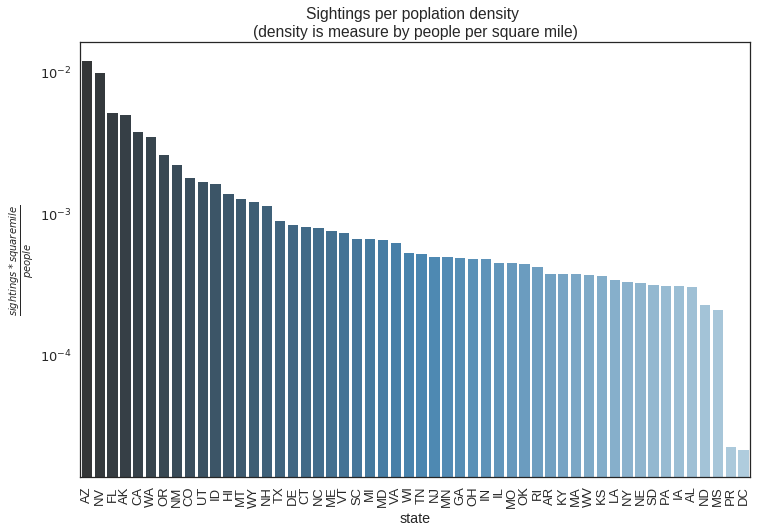

In [21]:
sns.barplot(x='state', y='normalized_by_density', 
            data=states_data.reset_index().sort_values(by='normalized_by_density', ascending=False),
            palette='Blues_d', log=True);
plt.xticks(rotation=90);
plt.ylabel(r'$\frac{sightings * square mile}{people}$');
plt.title('Sightings per poplation density \n(density is measure by people per square mile)');

### Time

[[back to the top]](#the-top)

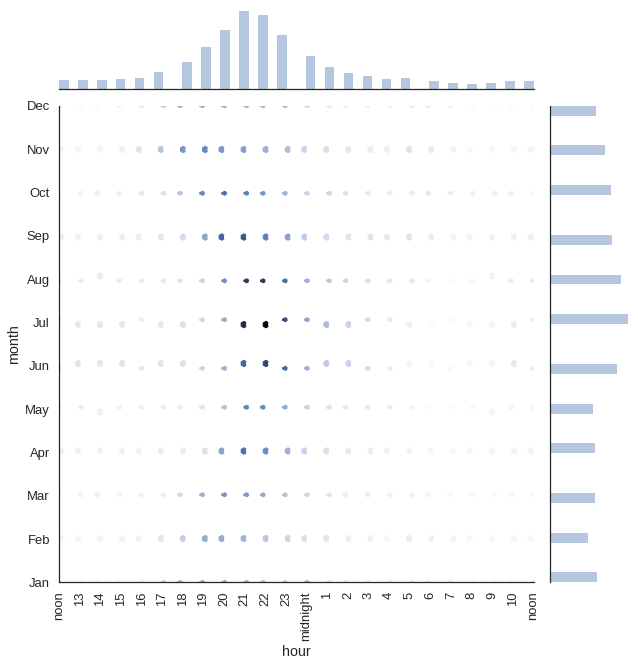

In [22]:
time = data.loc[:, [HOUR, MONTH]].copy()
# transform the hours column such that midnight will be centered in the plot
time[HOUR] += 12
time[HOUR] %= 24
ax = sns.jointplot(x=HOUR, y=MONTH, data=time, kind='hex',
                   stat_func=None, xlim=(0,23), ylim=(1,12), size=9);

xticks = [str(i) for i in range(12,24)]
xticks += [str(i) for i in range(12)]
xticks[0] = 'noon'
xticks[12] = 'midnight'
xticks[-1] = 'noon'
ax.ax_joint.set_xticks(range(24));
ax.ax_joint.set_xticklabels(xticks, rotation=90);
ax.ax_joint.set_yticks(range(1, 13));
ax.ax_joint.set_yticklabels(['Jan', 'Feb', 'Mar',
                             'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep',
                             'Oct', 'Nov', 'Dec']);

Most of the UFOs are seen in night time (~22:00) at July (which is summer in the US). The night part is obvious - human sight at night is much worse than in daytime, and we can easily misidentify flying objects. The summer part is a bit more difficult. Perhaps the fact the sky is usually clear at summer makes it easier to see objects in the sky in general, and spot UFOs in particular. Then again, the difference in sightings count in July to any other month isn't as dramatic as in the hours axis.